# CMIP6 Soil temperature bias adjustment

This notebook contains some explortory work for bias-adjustment of soil temperature data from CMIP6 using some reference data collected from the Bonanza Creek LTER. It is not complete but I am keeping it in here because it could be a could reference for continuation one day. 

In [1]:
# done with snap-geo env
import io
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import requests
import matplotlib.pyplot as plt
from multiprocessing import Pool
from dask.distributed import LocalCluster, Client
from xclim import sdba, indices
from xclim.sdba.detrending import LoessDetrend
from xclim.core.units import convert_units_to
from xarray.coding.calendar_ops import convert_calendar

cmip6_dir = Path("/beegfs/CMIP6/arctic-cmip6/CMIP6")

Get requests for soil and air temp data at LTER2, the floodplain site in the LTER:

In [2]:
# link for BC LTER 2 (floodplain) soil temp data
st_lter2_url = "https://www.lter.uaf.edu/php/download_data.php?f=/data_files/ascii/script_outputs/3_ST_LTER2_1988-2021.txt"
st_r = requests.get(st_lter2_url)

# temperature url
ta_lter2_url = "https://www.lter.uaf.edu/php/download_data.php?f=/data_files/ascii/script_outputs/1_AT_LTER2_1988-2021.txt"
at_r = requests.get(ta_lter2_url)

Pull the data streams into dataframes:

In [3]:
def convert_to_int(x):
    try:
        return int(x)
    except ValueError:
        if x == "Surface":
            return 0


st_df = pd.read_csv(
    io.StringIO(st_r.content.decode("utf8")),
    sep=",",
    usecols=["date", "tempC", "depth"],
    converters={"depth": convert_to_int},
    parse_dates=["date"],
)

st_df = (
    st_df.groupby(["date", "depth"])["tempC"]
    .agg(["min", "mean", "max"])
    .reset_index()
    .pivot(index="date", columns="depth", values=["min", "mean", "max"])
)

st_df.columns = ["_".join(("st", j, str(k))) for j, k in st_df.columns]

In [4]:
at_df = pd.read_csv(
    io.StringIO(at_r.content.decode("utf8")),
    usecols=["date", "airtemp", "airtemp_max", "airtemp_min", "height"],
    parse_dates=["date"],
)

df1, df2, df3 = [
    at_df.groupby(["date", "height"])["airtemp_max"].agg("max").reset_index(),
    at_df.groupby(["date", "height"])["airtemp"].agg("mean").reset_index(),
    at_df.groupby(["date", "height"])["airtemp_min"].agg("min").reset_index(),
]

keys = ["date", "height"]

at_df = pd.merge(pd.merge(df1, df2, on=keys), df3, on=keys).pivot(
    index="date", columns="height", values=["airtemp_max", "airtemp", "airtemp_min"]
)


at_df.columns = ["_".join((j, str(k))) for j, k in at_df.columns]
at_df

,airtemp_max_50,airtemp_max_150,airtemp_50,airtemp_150,airtemp_min_50,airtemp_min_150
date,,,,,,
1988-06-02,NaN,18.100,NaN,12.154545,NaN,8.00
1988-06-03,NaN,22.500,NaN,13.945833,NaN,7.40
1988-06-04,NaN,24.100,NaN,15.529167,NaN,4.20
1988-06-05,NaN,28.000,NaN,16.362500,NaN,3.60
1988-06-06,NaN,18.600,NaN,13.537500,NaN,10.50
...,...,...,...,...,...,...
2021-12-27,0.728,2.801,-3.513792,-5.752833,-7.604,-12.54
2021-12-28,-3.904,0.801,-5.082375,-6.570625,-6.957,-9.97
2021-12-29,-2.337,0.784,-2.904958,-5.258458,-4.112,-10.36


In [5]:
# merge the two dataframes
ref_ds = pd.merge(
    st_df,
    at_df,
    on=["date"],
).to_xarray()

Okay let's try bias-adjusting the soil temperatures. Both datasets (measured data and CMIP6) have mean temperature at 5 cm, so let's start with that. 

Subset to the grid cell intersected by the LTER site and pull data at 5 cm depth. Also subset the data temporally, to a window of 1995-01-01 - 2014-12-31, plus the preceding and following 15 days (for a 31-day grouping window).

In [6]:
cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(cluster)

In [6]:
# all files have date strings of format "YYYYMMDD-YYYYMMDD". Use this info to choose the files that cover a given time period
def get_files_for_period(files, start_date, end_date):
    def parse_date(f, which):
        which_lu = {"start": 0, "end": 1}
        return int(f.name.split(".")[0].split("_")[-1].split("-")[which_lu[which]])

    fps = [
        f
        for f in files
        if not (
            (parse_date(f, "end") < start_date) or (parse_date(f, "start") > end_date)
        )
    ]
    return sorted(fps)


def get_sim_fps(cmip6_dir, model, scenario, start_date, end_date):
    all_fps = list(
        cmip6_dir.glob(f"ScenarioMIP/*/{model}/{scenario}/*/Eday/tsl/*/*/tsl_Eday*.nc")
    )
    return get_files_for_period(all_fps, start_date, end_date)


def get_hist_fps(cmip6_dir, model, start_date, end_date):
    all_fps = list(
        cmip6_dir.glob(f"CMIP/*/{model}/historical/*/Eday/tsl/*/*/tsl_Eday*.nc")
    )
    return get_files_for_period(all_fps, start_date, end_date)

In [7]:
# prep reference data
# aren't combining historical + scenario data to get the extra 15 days for bc yet
ref_start_date = "1994-12-17"
ref_end_date = "2014-12-30"
ref_time_slice = slice(ref_start_date, ref_end_date)
ref = ref_ds["st_mean_5"].sel(date=ref_time_slice).rename({"date": "time"})
ref.attrs["units"] = "degC"
ref = convert_calendar(ref, "noleap", align_on="date")

Since we only care about a single pixel in any of the simulated data - that one which overlaps the given point - we are just gonna use multiprocessing to open files in parallel and extract from that single pixel. 

In [94]:
def open_and_extract(fp, sel_di):
    "open and extract by sel_di from a single file"
    with xr.open_dataset(fp, engine="h5netcdf") as ds:
        da = ds["tsl"].sel(sel_di, method="nearest")

    return da


def extract_across_files(fps, sel_di, ncpus=16):
    "extract across files"
    with Pool(ncpus) as pool:
        das = pool.starmap(open_and_extract, [(fp, sel_di) for fp in fps])

    da = xr.concat(das, dim="time")
    da = convert_units_to(da, "degC")
    da = convert_calendar(da, "noleap", align_on="date")
    # some models have hour values of 0 instead of 12. Just shifting those to make them consistent
    if da.time[0].dt.hour == 0:
        da["time"] = xr.CFTimeIndex.shift(da.time, periods=12, freq="h")

    # drop these variables as they are not consistent across models
    da = da.drop_vars(["depth", "lat", "lon"])

    return da

In [11]:
lon = -148.2549125
lat = 64.69889576
depth = 0.05
sel_di = {"lat": lat, "lon": lon + 180, "depth": depth}


def train_hist_adj(
    ref,
    cmip6_dir,
    model,
    det,
):
    hist_fps = get_hist_fps(
        cmip6_dir,
        model,
        int(ref.time.values[0].strftime("%Y%m%d")),
        int(ref.time.values[-1].strftime("%Y%m%d")),
    )

    if len(hist_fps) == 0:
        print(f"No historical files found for {model}")
        return None, None

    hist = extract_across_files(hist_fps, sel_di).sel(time=ref_time_slice)

    kind = "+"
    train_kwargs = dict(
        ref=ref,
        hist=hist,
        nquantiles=50,
        group="time.dayofyear",
        window=31,
        kind=kind,
    )

    dqm = sdba.DetrendedQuantileMapping.train(**train_kwargs)

    hist_adj = (
        (
            dqm.adjust(hist, extrapolation="constant", interp="nearest", detrend=det)
            # in testing, adjusted outputs are oriented lat, lon, time for some reason
        )
        .rename("tsl")
        .assign_coords({"model": model, "scenario": "historical"})
        .expand_dims(["model", "scenario"])
    )

    return dqm, hist_adj


def adjust_sim(dqm, cmip6_dir, model, scenario, det):
    start_date, end_date = "2015-01-01", "2099-12-30"
    sim_fps = get_sim_fps(
        cmip6_dir,
        model,
        scenario,
        int(start_date.replace("-", "")),
        int(end_date.replace("-", "")),
    )

    if len(sim_fps) == 0:
        print(f"No scenario files found for {model} {scenario}")
        return None, None

    sim = extract_across_files(sim_fps, sel_di).sel(time=slice(start_date, end_date))

    sim_adj = (
        (
            dqm.adjust(sim, extrapolation="constant", interp="nearest", detrend=det)
            # in testing, adjusted outputs are oriented lat, lon, time for some reason
        )
        .rename("tsl")
        .assign_coords({"model": model, "scenario": scenario})
        .expand_dims(["model", "scenario"])
    )

    return sim, sim_adj


models = [
    # those without historical tsl are commented out
    # "GFDL-ESM4",
    # "KACE-1-0-G",
    # "CNRM-CM6-1-HR",
    "NorESM2-MM",
    # "TaiESM1",
    "HadGEM3-GC31-MM",
    "HadGEM3-GC31-LL",
    "MIROC6",  # available under 6hrPlevPt
    # "EC-Earth3-Veg",
    "CESM2",
    "MPI-ESM1-2-HR",  # avialable under 6hrPlevPt
    # "MRI-ESM2-0",
]

# Create the detrending object
det = LoessDetrend(group="time.dayofyear", d=0, niter=1, f=0.2, weights="tricube")

dqm_lu = {}
sim_das = []
adj_das = []

Only a few models have soil temp data currently, run the adjustment for those:

In [12]:
for model in ["NorESM2-MM", "HadGEM3-GC31-MM", "HadGEM3-GC31-LL", "CESM2"]:
    dqm, hist_adj = train_hist_adj(
        ref,
        cmip6_dir,
        model,
        det,
    )

    dqm_lu[model] = dqm
    adj_das.append(hist_adj)
    print(f"Finished {model} historical")

    for scenario in ["ssp245", "ssp370", "ssp585"]:
        sim, adj = adjust_sim(dqm, cmip6_dir, model, scenario, det)
        adj_das.append(adj)
        sim_das.append(sim)
        print(f"Finished {model} {scenario}")

Finished NorESM2-MM historical
Finished NorESM2-MM ssp245
Finished NorESM2-MM ssp370
Finished NorESM2-MM ssp585
Finished HadGEM3-GC31-MM historical
No scenario files found for HadGEM3-GC31-MM ssp245
Finished HadGEM3-GC31-MM ssp245
No scenario files found for HadGEM3-GC31-MM ssp370
Finished HadGEM3-GC31-MM ssp370
Finished HadGEM3-GC31-MM ssp585
Finished HadGEM3-GC31-LL historical
Finished HadGEM3-GC31-LL ssp245
No scenario files found for HadGEM3-GC31-LL ssp370
Finished HadGEM3-GC31-LL ssp370
Finished HadGEM3-GC31-LL ssp585


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'tsl' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'tsl' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


Finished CESM2 historical


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'tsl' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'tsl' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


Finished CESM2 ssp245


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'tsl' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'tsl' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


Finished CESM2 ssp370


/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'tsl' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/kmredilla/miniconda3/envs/snap-geo/lib/python3.11/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'tsl' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


Finished CESM2 ssp585


Merge and tidy the adjusted data:

In [115]:
adj_das = [da for da in adj_das if da is not None]

for da in adj_das:
    if da.time.dt.hour.values[0] == 0:
        da["time"] = xr.CFTimeIndex.shift(da.time, periods=12, freq="h")

adj_das = [da.drop_vars(["lat", "lon"]) for da in adj_das]

adj_ds = xr.merge(adj_das)

# add decade coordinate for grouping
year = adj_ds.time.dt.year
# get decade from the year

adj_ds

Try out the frost-free-season index, even though that is usually used for air temperature. Planting can't occur in most places until the ground is actually unfrozen! Add some temporal groupings like 10- and 20-year periods.

In [225]:
ffss = indices.frost_free_season_start(adj_ds["tsl"].sel(time=slice("2020", "2100")))


def assign_decade(da):
    year = da.time.dt.year
    decade = (year // 10) * 10
    return da.assign_coords({"decade": decade})


ffss = assign_decade(ffss)


def assign_twenty_year_period(da):
    year = da.time.dt.year
    twodecade = (year // 20) * 20
    return da.assign_coords({"twodecade": twodecade})


ffss = assign_twenty_year_period(ffss)

Make a first plot with all models and scenarios:

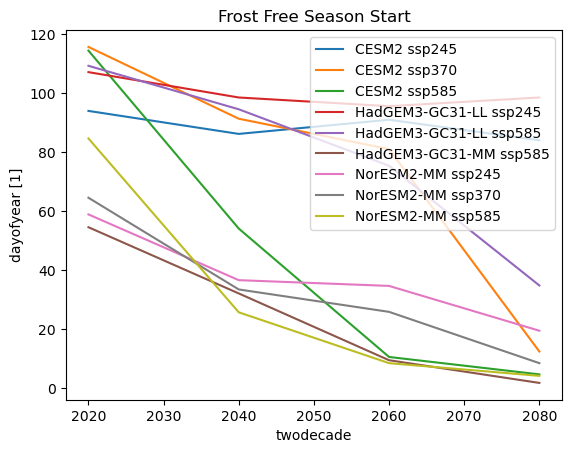

In [234]:
for model in ffss.model.values:
    for scenario in ffss.scenario.values:
        tmp = ffss.sel(model=model, scenario=scenario)
        if np.all(np.isnan(tmp)):
            continue
        tmp.groupby("twodecade").mean().plot(x="twodecade", label=f"{model} {scenario}")

plt.title("Frost Free Season Start")
plt.legend()

Growin season length:

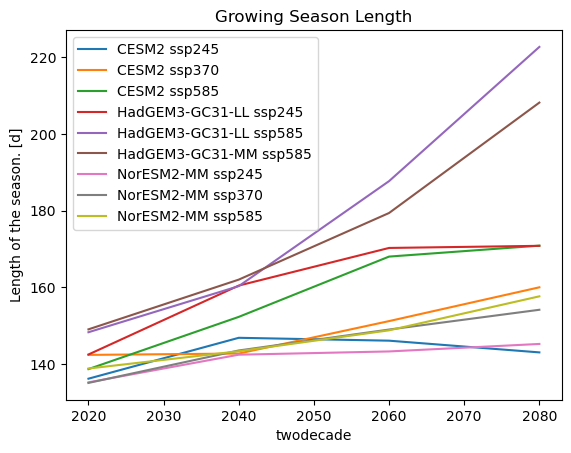

In [247]:
gsl = indices.growing_season_length(adj_ds["tsl"].sel(time=slice("2020", "2100")))
# plot like above
gsl = assign_twenty_year_period(gsl)

for model in gsl.model.values:
    for scenario in gsl.scenario.values:
        tmp = gsl.sel(model=model, scenario=scenario)
        if np.all(tmp == 0):
            continue
        tmp.groupby("twodecade").mean().plot(x="twodecade", label=f"{model} {scenario}")

plt.title("Growing Season Length")
plt.legend()

In [ ]:
# links for Permafrost Lab data, not sure if I'll use

# urls are not consistent so just listing them all
# data are not consistent either, would need some tedious preprocessing to standardize

urls = [
    "http://permafrost.gi.alaska.edu/sites/default/files/site_data/UF_08.xls",
    "http://permafrost.gi.alaska.edu/sites/default/files/site_data/uf_09.xls",
    "http://permafrost.gi.alaska.edu/sites/default/files/site_data/UF_10.xls",
    "http://permafrost.gi.alaska.edu/sites/default/files/site_data/UF_11.xls",
    "http://permafrost.gi.alaska.edu/sites/default/files/site_data/uf_daily_2012.xls",
    "http://permafrost.gi.alaska.edu/sites/default/files/site_data/UF_daily_2013.xls",
    "https://permafrost.gi.alaska.edu/sites/default/files/site_data/UF_daily_2014.xls",
    "https://permafrost.gi.alaska.edu/sites/default/files/site_data/UF_daily_2015.xls",
    "https://permafrost.gi.alaska.edu/sites/default/files/site_data/UF_daily_2016.xls",
    "http://permafrost.gi.alaska.edu/sites/default/files/site_data/UF_daily_2017.xls",
    "https://permafrost.gi.alaska.edu/sites/default/files/site_data/UF1_daily_2018.csv",
    "https://permafrost.gi.alaska.edu/sites/default/files/users/veromanovsky/US_UFF_102_2019-06-01_2020-05-31_daily.csv",
    "https://permafrost.gi.alaska.edu/sites/default/files/users/veromanovsky/US_UFF_102_2020-06-01_2021-05-31_daily.csv",
    "https://permafrost.gi.alaska.edu/sites/default/files/users/veromanovsky/US_UFF_102_2021-06-01_2022-04-23_daily.csv",
]

In [52]:
# in case interested in using these data, I think there was some SSL trickery involved for getting these urls
# not sure if this worked
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
df = pd.read_csv(urls[-4], header=10)